In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import  cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,confusion_matrix, classification_report
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2
from sklearn.model_selection import train_test_split
from scipy.stats import mode
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 

In [2]:
df = pd.read_csv("../1_data/data_clean.csv")

In [4]:
df.head()

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25,class
0,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,0.051836,...,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605,1
1,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,0.039827,...,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640,1
2,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,0.064220,...,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025,1
3,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,0.090408,...,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220,1
4,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,0.037528,...,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575,1


# 2. Feature selection - A multi-task learning framework

- For each task, split the data into training and test sets, train a RandomForest classifier, and store predictions.

- Combine the predictions from each task's classifier using majority voting to get the final prediction and evaluate the combined model's accuracy.

    - Initial Task-wise Feature Selection: Extract feature importances.

    - Combine Feature Importances: Aggregate feature importances across all tasks.

    - Select Top Features: Based on the aggregated importances, select the top features from the entire dataset.

- Train a Final Model: Train a final classifier using only the selected top features and evaluate its performance.

#### Split into tasks

In [5]:
X = df.drop(columns=['class'])
y = df['class']

In [6]:
X

,air_time1,disp_index1,gmrt_in_air1,gmrt_on_paper1,max_x_extension1,max_y_extension1,mean_acc_in_air1,mean_acc_on_paper1,mean_gmrt1,mean_jerk_in_air1,...,mean_gmrt25,mean_jerk_in_air25,mean_jerk_on_paper25,mean_speed_in_air25,mean_speed_on_paper25,num_of_pendown25,paper_time25,pressure_mean25,pressure_var25,total_time25
0,5160,0.000013,120.804174,86.853334,957,6601,0.361800,0.217459,103.828754,0.051836,...,249.729085,0.141434,0.024471,5.596487,3.184589,71,40120,1749.278166,296102.7676,144605
1,51980,0.000016,115.318238,83.448681,1694,6998,0.272513,0.144880,99.383459,0.039827,...,77.258394,0.049663,0.018368,1.665973,0.950249,129,126700,1504.768272,278744.2850,298640
2,2600,0.000010,229.933997,172.761858,2333,5802,0.387020,0.181342,201.347928,0.064220,...,193.667018,0.178194,0.017174,4.000781,2.392521,74,45480,1431.443492,144411.7055,79025
3,2130,0.000010,369.403342,183.193104,1756,8159,0.556879,0.164502,276.298223,0.090408,...,163.065803,0.113905,0.019860,4.206746,1.613522,123,67945,1465.843329,230184.7154,181220
4,2310,0.000007,257.997131,111.275889,987,4732,0.266077,0.145104,184.636510,0.037528,...,147.094679,0.121782,0.020872,3.319036,1.680629,92,37285,1841.702561,158290.0255,72575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169,2930,0.000010,241.736477,176.115957,1839,6439,0.253347,0.174663,208.926217,0.032691,...,200.568126,0.119152,0.020909,4.508709,2.233198,96,44545,1798.923336,247448.3108,80335
170,2140,0.000009,274.728964,234.495802,2053,8487,0.225537,0.174920,254.612383,0.032059,...,231.243565,0.174495,0.017640,4.685573,2.806888,84,37560,1725.619941,160664.6464,345835
171,3830,0.000008,151.536989,171.104693,1287,7352,0.165480,0.161058,161.320841,0.022705,...,177.935566,0.114472,0.017194,3.493815,2.510601,88,51675,1915.573488,128727.1241,83445
172,1760,0.000008,289.518195,196.411138,1674,6946,0.518937,0.202613,242.964666,0.090686,...,177.935566,0.114472,0.017194,3.493815,2.510601,88,51675,1915.573488,128727.1241,83445


In [7]:
y

0      1
1      1
2      1
3      1
4      1
      ..
169    0
170    0
171    0
172    0
173    0
Name: class, Length: 174, dtype: int64

#### Train classifiers for each task

In [8]:
tasks = {
    "Task1": df.iloc[:, 0:18],
    "Task2": df.iloc[:, 18:36],
    "Task3": df.iloc[:, 36:54],
    "Task4": df.iloc[:, 54:72],
    "Task5": df.iloc[:, 72:90],
    "Task6": df.iloc[:, 90:108],
    "Task7": df.iloc[:, 108:126],
    "Task8": df.iloc[:, 126:144],
    "Task9": df.iloc[:, 144:162],
    "Task10": df.iloc[:, 162:180],
    "Task11": df.iloc[:, 180:198],
    "Task12": df.iloc[:, 198:216],
    "Task13": df.iloc[:, 216:234],
    "Task14": df.iloc[:, 234:252],
    "Task15": df.iloc[:, 252:270],
    "Task16": df.iloc[:, 270:288],
    "Task17": df.iloc[:, 288:306],
    "Task18": df.iloc[:, 306:324],
    "Task19": df.iloc[:, 324:342],
    "Task20": df.iloc[:, 342:360],
    "Task21": df.iloc[:, 360:378],
    "Task22": df.iloc[:, 378:396],
    "Task23": df.iloc[:, 396:414],
    "Task24": df.iloc[:, 414:432],
    "Task25": df.iloc[:, 432:450]
}

In [9]:
classifiers = {}
predictions = []
feature_importances = {}

for task_name, task_df in tasks.items():
    X_train, X_test, y_train, y_test = train_test_split(task_df, y, test_size=0.2, random_state=42)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    classifiers[task_name] = clf
    
    # Store predictions
    pred = clf.predict(X_test)
    predictions.append(pred)
     # Store feature importances
    feature_importances[task_name] = clf.feature_importances_

#### Combine predictions

In [10]:
combined_predictions = np.array(predictions).T
final_predictions, _ = mode(combined_predictions, axis=1)
final_predictions = final_predictions.flatten()

# Evaluate the combined predictions
accuracy = accuracy_score(y_test, final_predictions)
print(f"Combined accuracy: {accuracy}")


# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report for more detailed evaluation
class_report = classification_report(y_test, final_predictions, target_names=['H', 'P'])
print("Classification Report:")
print(class_report)


Combined accuracy: 0.8285714285714286
Confusion Matrix:
[[14  1]
 [ 5 15]]
Classification Report:
              precision    recall  f1-score   support

           H       0.74      0.93      0.82        15
           P       0.94      0.75      0.83        20

    accuracy                           0.83        35
   macro avg       0.84      0.84      0.83        35
weighted avg       0.85      0.83      0.83        35



/var/folders/m2/r3np675n07xdfhh3c3947st80000gn/T/ipykernel_26147/478879389.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  final_predictions, _ = mode(combined_predictions, axis=1)


#### Feature selection

In [ ]:
# Get the top features for each task
top_features = {}

for task_name, importances in feature_importances.items():
    sorted_indices = np.argsort(importances)[::-1]  # Sort in descending order
    top_indices = sorted_indices[:5]  # Get top 5 features
    top_features[task_name] = task_df.columns[top_indices]


In [12]:
# Aggregate feature importances across all tasks
aggregated_importances = np.zeros(X.shape[1])
for task_name, importances in feature_importances.items():
    start_idx = int(task_name.replace('Task', '')) * 18 - 18  
    end_idx = start_idx + len(importances)
    aggregated_importances[start_idx:end_idx] += importances

# Normalize aggregated importances
aggregated_importances /= len(tasks)

# Select top features from the whole dataset
sorted_indices = np.argsort(aggregated_importances)[::-1]  # Sort in descending order

#### Find the optimal number of top features

Number of features: 1, Accuracy: 0.8
Number of features: 2, Accuracy: 0.8571428571428571
Number of features: 3, Accuracy: 0.8857142857142857
Number of features: 4, Accuracy: 0.8
Number of features: 5, Accuracy: 0.8571428571428571
Number of features: 6, Accuracy: 0.8285714285714286
Number of features: 7, Accuracy: 0.8571428571428571
Number of features: 8, Accuracy: 0.8571428571428571
Number of features: 9, Accuracy: 0.8571428571428571
Number of features: 10, Accuracy: 0.8857142857142857
Number of features: 11, Accuracy: 0.8857142857142857
Number of features: 12, Accuracy: 0.8857142857142857
Number of features: 13, Accuracy: 0.8857142857142857
Number of features: 14, Accuracy: 0.8857142857142857
Number of features: 15, Accuracy: 0.9142857142857143
Number of features: 16, Accuracy: 0.9142857142857143
Number of features: 17, Accuracy: 0.9142857142857143
Number of features: 18, Accuracy: 0.9428571428571428
Number of features: 19, Accuracy: 0.9428571428571428
Number of features: 20, Accuracy

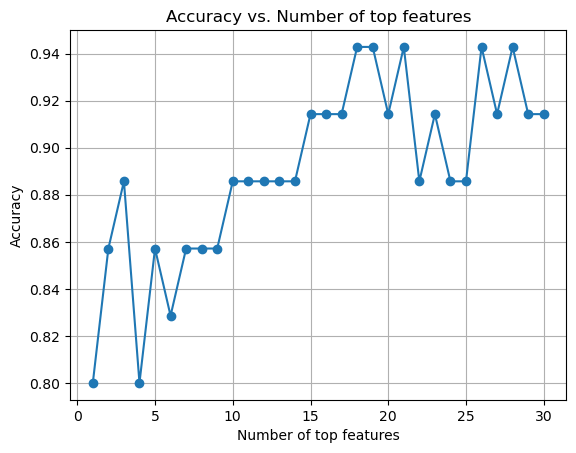

In [13]:
max_features_to_try = 30  # Try up to 30 features
results = []

for num_features in range(1, max_features_to_try + 1):
    # Select top num_features features
    top_indices = sorted_indices[:num_features]
    top_features = X.columns[top_indices]
    X_selected = X[top_features]
    
    # Example: Using RandomForestClassifier for classification task
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Evaluating performance with accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    results.append((num_features, accuracy))
    
# Print or plot results to find the optimal number of features
for num_features, accuracy in results:
    print(f"Number of features: {num_features}, Accuracy: {accuracy}")

# Plot the results to visualize the trend
plt.plot([num_features for num_features, _ in results], [accuracy for _, accuracy in results], marker='o')
plt.xlabel('Number of top features')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of top features')
plt.grid(True)
plt.show()


The optimal number of top features can be:

    Number of features: 18, Accuracy: 0.9428571428571428
    Number of features: 19, Accuracy: 0.9428571428571428
    Number of features: 26, Accuracy: 0.9428571428571428
    Number of features: 27, Accuracy: 0.9428571428571428

#### Cross-validation with K = 5 to find the optimal number of features

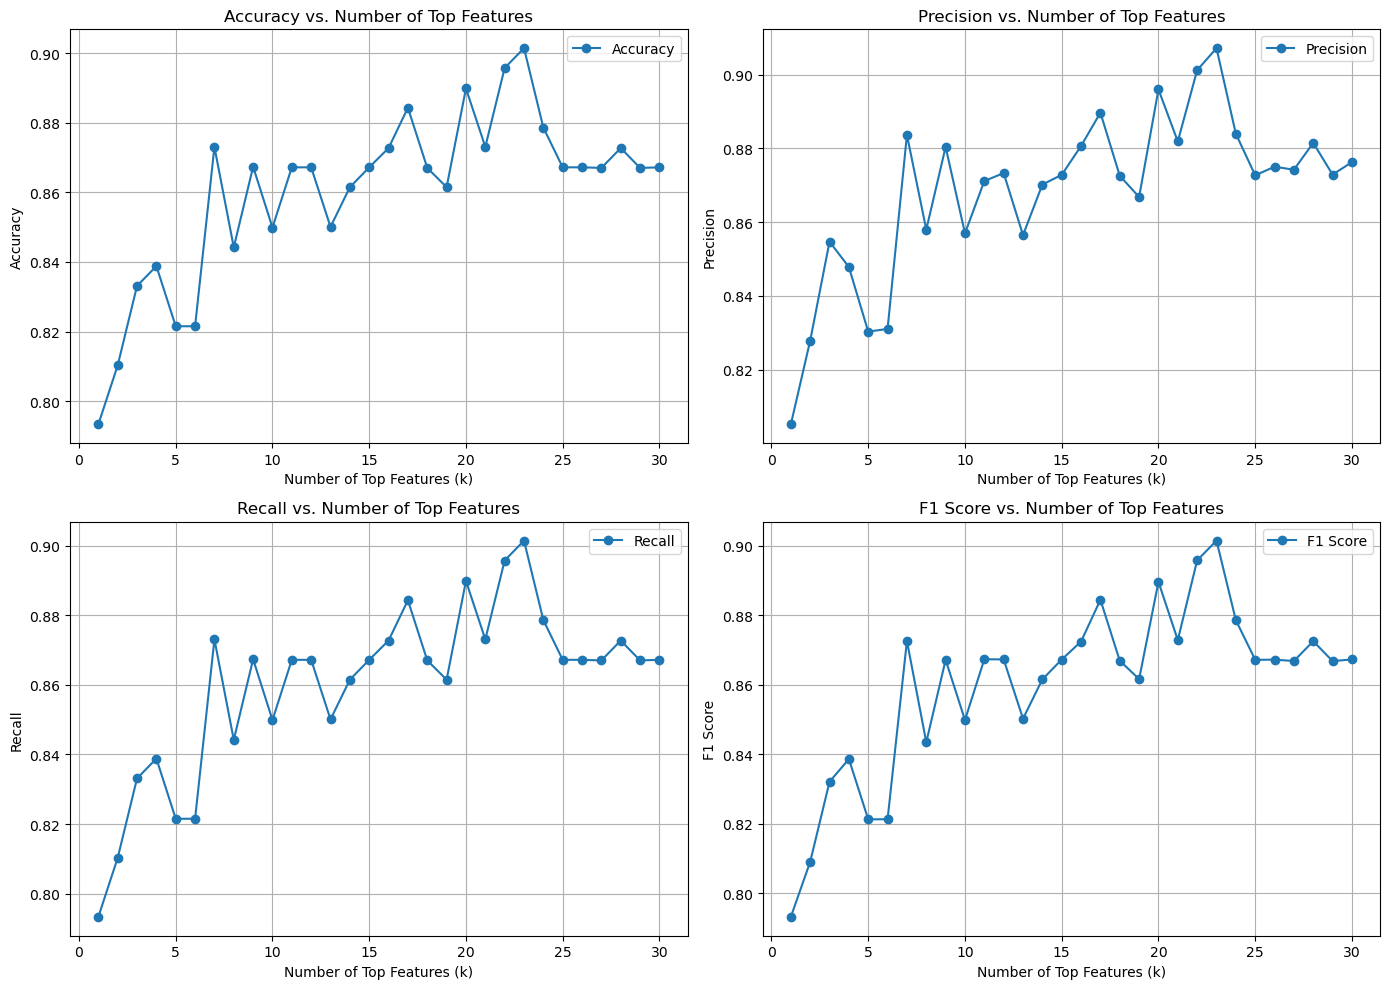

In [14]:
# Define the range of k values
k_values = range(1, max_features_to_try + 1)

# Initialize lists to store metrics for each k
accuracies = []
precisions = []
recalls = []
f1_scores = []

# Initialize KFold for cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)

for num_features in k_values:
    # Initialize lists to store metrics for this number of features
    cv_accuracies = []
    cv_precisions = []
    cv_recalls = []
    cv_f1_scores = []
    
    # Select top num_features features
    top_indices = sorted_indices[:num_features]
    top_features = X.columns[top_indices]
    X_selected = X[top_features]
    
    # Perform cross-validation
    for train_index, test_index in cv.split(X_selected):
        X_train, X_test = X_selected.iloc[train_index], X_selected.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Example: Using RandomForestClassifier for classification task
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # Store metrics for this fold
        cv_accuracies.append(accuracy)
        cv_precisions.append(precision)
        cv_recalls.append(recall)
        cv_f1_scores.append(f1)
    
    # Average metrics across folds
    accuracies.append(np.mean(cv_accuracies))
    precisions.append(np.mean(cv_precisions))
    recalls.append(np.mean(cv_recalls))
    f1_scores.append(np.mean(cv_f1_scores))

# Plotting
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(k_values, accuracies, marker='o', label='Accuracy')
plt.xlabel('Number of Top Features (k)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of Top Features')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(k_values, precisions, marker='o', label='Precision')
plt.xlabel('Number of Top Features (k)')
plt.ylabel('Precision')
plt.title('Precision vs. Number of Top Features')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(k_values, recalls, marker='o', label='Recall')
plt.xlabel('Number of Top Features (k)')
plt.ylabel('Recall')
plt.title('Recall vs. Number of Top Features')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(k_values, f1_scores, marker='o', label='F1 Score')
plt.xlabel('Number of Top Features (k)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Number of Top Features')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [15]:
# After running the code to compute accuracies, precisions, recalls, f1_scores

# Find the index of the maximum F1 score
best_index = np.argmax(recalls)
best_k = k_values[best_index]

best_accuracy = accuracies[best_index]
best_precision = precisions[best_index]
best_recall = recalls[best_index]
best_f1_score = f1_scores[best_index]

print(f"Best number of features (k): {best_k}")
print(f"Corresponding metrics:")
print(f"  - Accuracy: {best_accuracy}")
print(f"  - Precision: {best_precision}")
print(f"  - Recall: {best_recall}")
print(f"  - F1 Score: {best_f1_score}")


Best number of features (k): 23
Corresponding metrics:
  - Accuracy: 0.9015126050420168
  - Precision: 0.907155314757482
  - Recall: 0.9015126050420168
  - F1 Score: 0.9015129315406455


#### Train and evaluate the model with top 22 important features

In [16]:

top_indices = sorted_indices[:22]  # Select top 22 features
top_features = X.columns[top_indices]


In [17]:
# Display top features for the whole dataset
print(f"Top features for the whole dataset: {list(top_features)}")

Top features for the whole dataset: ['total_time23', 'total_time6', 'total_time9', 'total_time15', 'air_time15', 'air_time16', 'total_time13', 'air_time6', 'air_time23', 'total_time3', 'total_time24', 'air_time5', 'total_time7', 'air_time13', 'air_time24', 'total_time2', 'air_time17', 'air_time22', 'pressure_mean4', 'total_time16', 'max_y_extension20', 'total_time12']


In [18]:
# Train a final classifier using the top 22 features
X_top = X[top_features]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)
final_clf_22 = RandomForestClassifier(n_estimators=100, random_state=42)
final_clf_22.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [19]:
# Evaluate the final classifier
final_pred = final_clf_22.predict(X_test)
final_accuracy = accuracy_score(y_test, final_pred)
print(f"Final model accuracy with top features: {final_accuracy}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, final_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report for more detailed evaluation
class_report = classification_report(y_test, final_pred, target_names=['H', 'P'])
print("Classification Report:")
print(class_report)

Final model accuracy with top features: 0.8857142857142857
Confusion Matrix:
[[14  1]
 [ 3 17]]
Classification Report:
              precision    recall  f1-score   support

           H       0.82      0.93      0.88        15
           P       0.94      0.85      0.89        20

    accuracy                           0.89        35
   macro avg       0.88      0.89      0.88        35
weighted avg       0.89      0.89      0.89        35



#### Ensemble Learning 
     - Basic Learners: Train different classifiers (e.g., SVM, NB, DTree, MLP, KNN, RFC, LR) on the selected feature subset obtained from the GA.
    - Meta-Learner: Use the AdaBoost algorithm as the meta-learner. The meta-learner combines the predictions from the basic learners to make the final prediction.


#### Steps: 
    
    Initialize the Basic Learners: Train multiple base classifiers on your data. These classifiers can be any of the classifiers you've previously defined, such as SVM, Naive Bayes, Decision Tree, etc.

    Generate Predictions: Once the basic learners are trained, use them to generate predictions (class labels or probabilities) for each instance in your dataset.

    Initialize AdaBoost: AdaBoost is a boosting ensemble method that combines predictions from weak learners to improve overall performance. It focuses more on instances that were misclassified by previous classifiers.

    Train AdaBoost: AdaBoost uses these predictions to adjust weights on the instances and create a final strong learner (ensemble model).

In [20]:
# Define basic learners (classifiers)
svm_clf = SVC(kernel='linear', random_state=42)
nb_clf = GaussianNB()
dt_clf = DecisionTreeClassifier(random_state=42)
mlp_clf = MLPClassifier(random_state=42)
knn_clf = KNeighborsClassifier()
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression(random_state=42)

# Train each classifier on the training data
svm_clf.fit(X_train, y_train)
nb_clf.fit(X_train, y_train)
dt_clf.fit(X_train, y_train)
mlp_clf.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
lr_clf.fit(X_train, y_train)

/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [21]:
# Generate predictions from each basic learner
svm_preds = svm_clf.predict(X_train)
nb_preds = nb_clf.predict(X_train)
dt_preds = dt_clf.predict(X_train)
mlp_preds = mlp_clf.predict(X_train)
knn_preds = knn_clf.predict(X_train)
rf_preds = rf_clf.predict(X_train)
lr_preds = lr_clf.predict(X_train)

# Stack predictions horizontally (along axis 1)
stacked_preds_train = np.column_stack((svm_preds, nb_preds, dt_preds, mlp_preds, knn_preds, rf_preds, lr_preds))

In [22]:
# Initialize your meta-learner ( AdaBoost)

adaboost_clf = AdaBoostClassifier(estimator=None, n_estimators=50, random_state=42)

# Train the AdaBoost meta-learner on the stacked predictions
adaboost_clf.fit(stacked_preds_train, y_train)

/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(random_state=42)

In [23]:
# Generate predictions from each basic learner on the test set
svm_test_preds = svm_clf.predict(X_test)
nb_test_preds = nb_clf.predict(X_test)
dt_test_preds = dt_clf.predict(X_test)
mlp_test_preds = mlp_clf.predict(X_test)
knn_test_preds = knn_clf.predict(X_test)
rf_test_preds = rf_clf.predict(X_test)
lr_test_preds = lr_clf.predict(X_test)

# Stack predictions for the test set
stacked_preds_test = np.column_stack((svm_test_preds, nb_test_preds, dt_test_preds, mlp_test_preds, knn_test_preds, rf_test_preds, lr_test_preds))


In [24]:
len(X_test.columns)

22

In [25]:
# Make predictions using the trained AdaBoost meta-learner
adaboost_test_preds = adaboost_clf.predict(stacked_preds_test)


In [26]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, adaboost_test_preds)
precision = precision_score(y_test, adaboost_test_preds)
recall = recall_score(y_test, adaboost_test_preds)
f1 = f1_score(y_test, adaboost_test_preds)
conf_matrix = confusion_matrix(y_test, adaboost_test_preds)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8571
Precision: 0.9412
Recall: 0.8000
F1 Score: 0.8649
Confusion Matrix:
[[14  1]
 [ 4 16]]


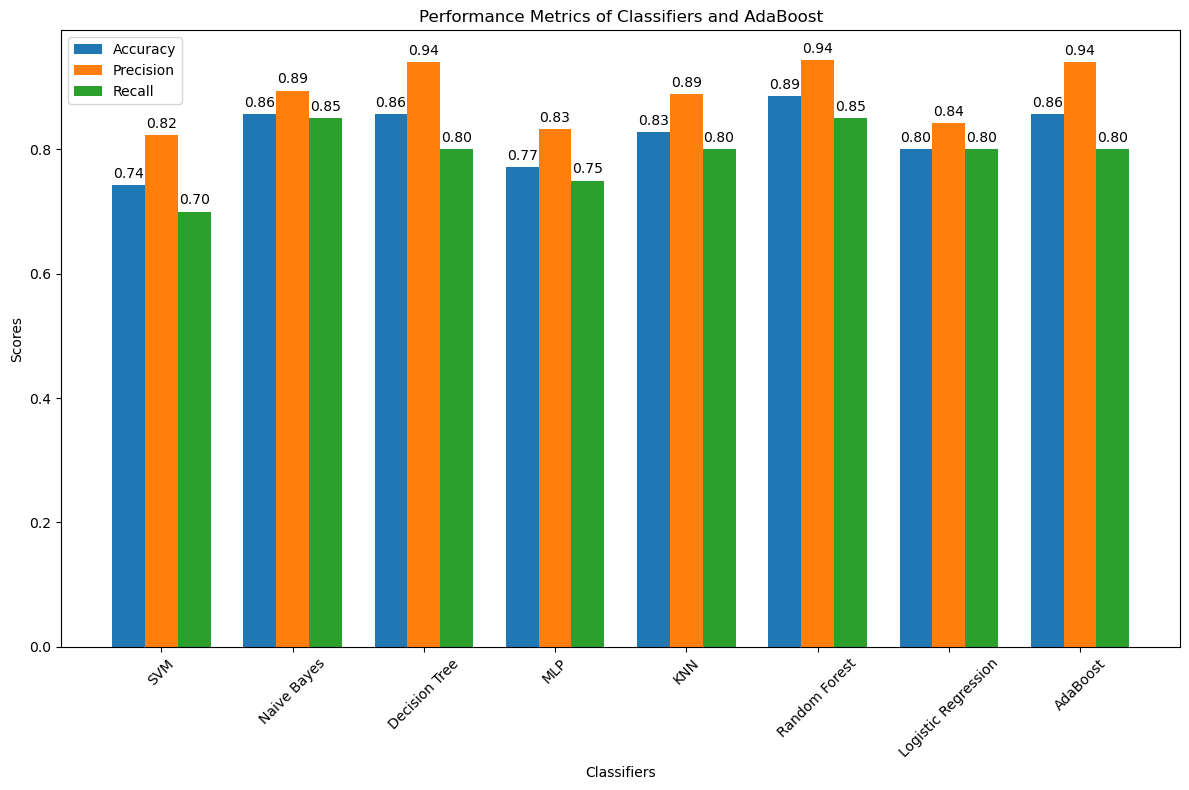

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score

# Sample data (replace with your actual metrics)
y_preds = {
    'SVM': svm_test_preds,
    'Naive Bayes': nb_test_preds,
    'Decision Tree': dt_test_preds,
    'MLP': mlp_test_preds,
    'KNN': knn_test_preds,
    'Random Forest': rf_test_preds,
    'Logistic Regression': lr_test_preds,
    'AdaBoost': adaboost_test_preds
}

# Calculate accuracy, precision, and recall for each classifier
accuracy_scores = {clf_name: accuracy_score(y_test, y_preds[clf_name]) for clf_name in y_preds}
precision_scores = {clf_name: precision_score(y_test, y_preds[clf_name]) for clf_name in y_preds}
recall_scores = {clf_name: recall_score(y_test, y_preds[clf_name]) for clf_name in y_preds}

# Plotting
labels = list(y_preds.keys())
x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))

rects1 = ax.bar(x - width, [accuracy_scores[clf_name] for clf_name in labels], width, label='Accuracy')
rects2 = ax.bar(x, [precision_scores[clf_name] for clf_name in labels], width, label='Precision')
rects3 = ax.bar(x + width, [recall_scores[clf_name] for clf_name in labels], width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Classifiers')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics of Classifiers and AdaBoost')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Function to add labels on top of the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.tight_layout()
plt.show()


#### CV for k=2, 5, and 10

In [28]:
# Define classifiers
classifiers = {
    'SVM': SVC(kernel='linear', random_state=42),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42)
}

# Define k values
k_values = [2, 5, 10]

# Define scoring metrics (accuracy, precision, recall)
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted')
}

# Perform cross-validation
results = {}
for clf_name, clf in classifiers.items():
    clf_results = {}
    for k in k_values:
        cv = KFold(n_splits=k, shuffle=True, random_state=42)
        scores_accuracy = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')
        scores_precision = cross_val_score(clf, X, y, cv=cv, scoring='precision_weighted')
        scores_recall = cross_val_score(clf, X, y, cv=cv, scoring='recall_weighted')
        
        clf_results[k] = {
            'accuracy': np.mean(scores_accuracy),
            'precision': np.mean(scores_precision),
            'recall': np.mean(scores_recall)
        }
    
    results[clf_name] = clf_results

# Print results (you can also store or visualize them)
for clf_name, clf_result in results.items():
    print(f"{clf_name}:")
    for k, metrics in clf_result.items():
        print(f"  k={k}: Accuracy={metrics['accuracy']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}")
    print()

/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/camiloestradasantos/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

SVM:
  k=2: Accuracy=0.759, Precision=0.761, Recall=0.759
  k=5: Accuracy=0.810, Precision=0.816, Recall=0.810
  k=10: Accuracy=0.816, Precision=0.825, Recall=0.816

Naive Bayes:
  k=2: Accuracy=0.839, Precision=0.847, Recall=0.839
  k=5: Accuracy=0.874, Precision=0.876, Recall=0.874
  k=10: Accuracy=0.885, Precision=0.895, Recall=0.885

Decision Tree:
  k=2: Accuracy=0.759, Precision=0.760, Recall=0.759
  k=5: Accuracy=0.793, Precision=0.806, Recall=0.793
  k=10: Accuracy=0.776, Precision=0.807, Recall=0.776

MLP:
  k=2: Accuracy=0.816, Precision=0.817, Recall=0.816
  k=5: Accuracy=0.845, Precision=0.853, Recall=0.845
  k=10: Accuracy=0.834, Precision=0.852, Recall=0.834

KNN:
  k=2: Accuracy=0.701, Precision=0.757, Recall=0.701
  k=5: Accuracy=0.713, Precision=0.766, Recall=0.713
  k=10: Accuracy=0.735, Precision=0.787, Recall=0.735

Random Forest:
  k=2: Accuracy=0.862, Precision=0.863, Recall=0.862
  k=5: Accuracy=0.844, Precision=0.851, Recall=0.844
  k=10: Accuracy=0.913, Precisi

#### Plot the results of recall across different values of k (2, 5, 10) for all classifiers

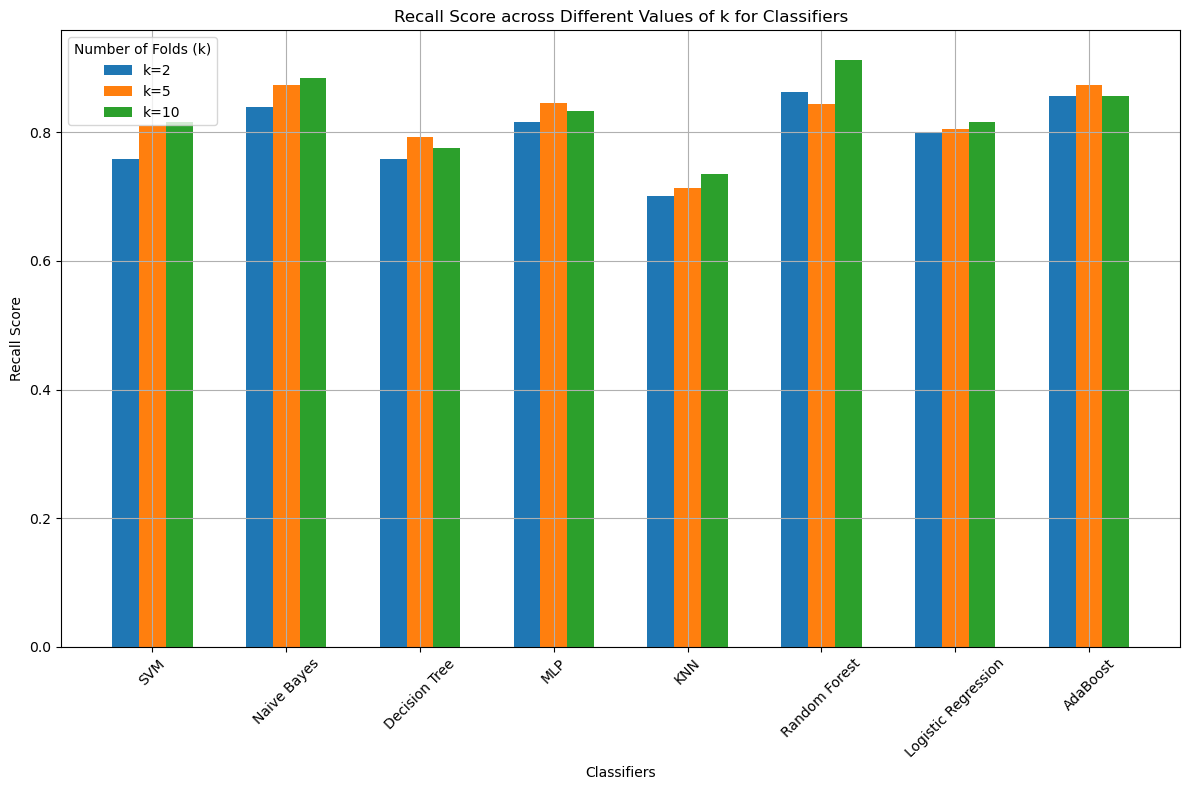

In [29]:
# Initialize empty dictionaries to store recall scores for each k
recall_scores = {2: {}, 5: {}, 10: {}}

# Populate recall_scores dictionary from 'results'
for clf_name, clf_result in results.items():
    for k, metrics in clf_result.items():
        recall_scores[k][clf_name] = metrics['recall']

# Prepare data for plotting
classifiers = list(results.keys())
k_values = [2, 5, 10]
recall_data = [[recall_scores[k][clf] for clf in classifiers] for k in k_values]

# Plotting
plt.figure(figsize=(12, 8))

bar_width = 0.2
x = np.arange(len(classifiers))

for i, k in enumerate(k_values):
    plt.bar(x + i * bar_width, recall_data[i], width=bar_width, label=f'k={k}')

plt.xlabel('Classifiers')
plt.ylabel('Recall Score')
plt.title('Recall Score across Different Values of k for Classifiers')
plt.xticks(x + bar_width, classifiers, rotation=45)
plt.legend(title='Number of Folds (k)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Best clasifier: Random Forest

In [30]:
# Train a final classifier using the top 22 features
X_top = X[top_features]
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)
final_clf_22 = RandomForestClassifier(n_estimators=100, random_state=42)
final_clf_22.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [31]:
# Evaluate the final classifier
final_pred = final_clf_22.predict(X_test)
final_accuracy = accuracy_score(y_test, final_pred)
print(f"Final model accuracy with top features: {final_accuracy}")

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, final_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report for more detailed evaluation
class_report = classification_report(y_test, final_pred, target_names=['H', 'P'])
print("Classification Report:")
print(class_report)

Final model accuracy with top features: 0.8857142857142857
Confusion Matrix:
[[14  1]
 [ 3 17]]
Classification Report:
              precision    recall  f1-score   support

           H       0.82      0.93      0.88        15
           P       0.94      0.85      0.89        20

    accuracy                           0.89        35
   macro avg       0.88      0.89      0.88        35
weighted avg       0.89      0.89      0.89        35



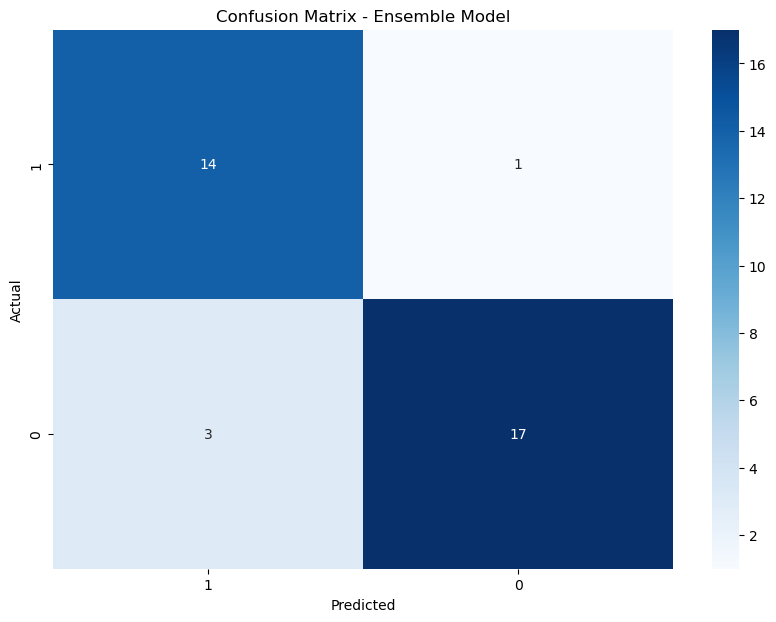

In [32]:
# Generate and plot the confusion matrix

cm = confusion_matrix(y_test, final_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y.unique(), yticklabels=y.unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Ensemble Model')
plt.show()

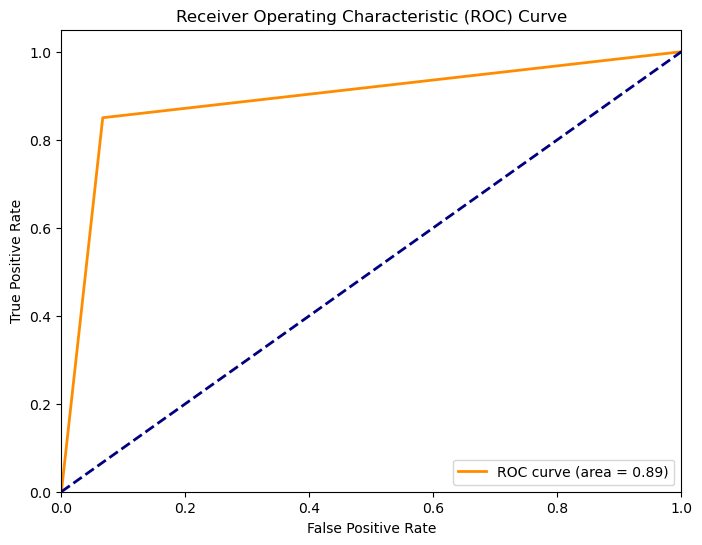

In [33]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, final_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()